# Group Members
Pierre Mercatoris – Pablo Bordons Estrada - Sergio Gámez Ruiz de Olano – Mohammadmehdi
Fayazbakhsh

# 2 st Assignment: Mixed-Integer Linear Programming

Generate random data, consider n=500 observations (i=1,…,500), from a predefined linear regression model with m=20 variables (j=1,…,20). Assume that the regression coefficients are integers so that −5 ≤ 𝛽 𝑗 ≤ 5. Assume also independent normal residuals.

$$ Y = \beta ' X + \epsilon $$

In [3]:
# Imports

import numpy as np
import pandas as pd
from sklearn.datasets import make_regression

from __future__ import division
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory


In [4]:
# Create random dataset 
i, j = 500, 20
reg = make_regression(i, j, coef=True)
Y = reg[1].reshape(i, 1)
X = np.column_stack((np.ones(i), np.asmatrix(reg[0])))
np.round(reg[2], 3)

array([  0.   ,   0.   ,  82.313,  33.63 ,   0.   ,   0.   ,   0.   ,
        39.641,  26.561,   0.   ,  54.388,  98.987,  75.47 ,   0.   ,
         0.   ,   0.   ,  35.26 ,  19.172,  74.58 ,   0.   ])

## Exercise 1

The classical least squares approach is to find the values of vector 𝛽 = (𝛽 1 , … , 𝛽 𝑗 , … , 𝛽 𝑚 ) 𝑇 so that:

$$ \min_{\beta} \sum^n_{i=1} (y_i - \beta ' x_i)^2 $$
    
where $x_i = (x_{1i} , … , x_{2i} , … , x_{mi} )$ 𝑇 for $ i = 1, ...,n.$

Estimate the value of the regression coefficients by using the analytical solution for the least squares estimation problem. Tip:

$$\beta_{ls} = (X^T X)^{-1}X^TY $$

In [5]:
# Calculate Beta normal equation
beta = np.linalg.inv(np.transpose(X)*X)*np.transpose(X)*Y
np.round(beta, 3)

array([[ -0.   ],
       [ -0.   ],
       [  0.   ],
       [ 82.313],
       [ 33.63 ],
       [ -0.   ],
       [  0.   ],
       [ -0.   ],
       [ 39.641],
       [ 26.561],
       [  0.   ],
       [ 54.388],
       [ 98.987],
       [ 75.47 ],
       [ -0.   ],
       [ -0.   ],
       [ -0.   ],
       [ 35.26 ],
       [ 19.172],
       [ 74.58 ],
       [ -0.   ]])

## Exercise 2

As an alternative, the least absolute value approach seeks to find the values of β by solving the following problem:

$$ \min_{\beta} \sum^n_{i=1} |y_i - \beta ' x_i| $$

Propose and implement in Pyomo an equivalent linear formulation for this problem. Compare the resulting β coefficients with the ones obtained in exercise 1).

$$ \min_{t,\beta}\sum^n_{i=1} t_i $$
$$s.t. \, -t \leq y-X\beta \leq t$$
$$t \geq 0 $$

In [6]:
nsample = 500
nvariables = 20
X0=np.ones([nsample, 1])
X1=np.random.uniform(0, 10, ([nsample,nvariables]))
X=np.concatenate([X0, X1], axis=1)
error=np.random.normal(0, 1, (nsample,1))
beta=np.random.uniform(-5, 5, size=([nvariables+1, 1]))
Y=np.dot(X, beta)+error
print(beta)

[[-3.06846628]
 [ 3.60589851]
 [-4.63226531]
 [-4.66391997]
 [-3.05908239]
 [-2.07107855]
 [ 0.52553705]
 [-0.41605418]
 [ 1.4360755 ]
 [-3.68407912]
 [-3.87788478]
 [ 3.22057276]
 [-1.73013175]
 [ 4.99459108]
 [ 4.39271309]
 [ 3.01233331]
 [-2.96366667]
 [ 4.10355123]
 [ 4.31601443]
 [-2.16117113]
 [-0.89755362]]


In [7]:
model = AbstractModel()


model.I = RangeSet(1, nsample)
model.J = RangeSet(1, nvariables+1)

model.B = Var(model.J, domain=Reals)

model.t = Var(model.I, domain=NonNegativeReals)


def obj_func(model):
    return sum(model.t[i] for i in model.I)
model.OBJ = Objective(rule=obj_func, sense=minimize)

def const1(model, i):
    return -(sum((model.B[j]*X[i-j, j-1]) for j in model.J)) - model.t[i] <= -Y[i-1]
model.const1 = Constraint(model.I, rule=const1)

def const2(model, i):
    return -(sum((model.B[j]*X[i-1, j-1]) for j in model.J)) + model.t[i] >= -Y[i-1]
model.const2 = Constraint(model.I, rule=const2)

def const3(model, i):
    return model.t[i] >= 0
model.const3 = Constraint(model.I, rule=const3)


In [8]:
instance = model.create_instance()
results = opt.solve(instance)
print(results)


Problem: 
- Lower bound: 12382.34858
  Upper bound: 12382.34858
  Number of objectives: 1
  Number of constraints: 1501
  Number of variables: 522
  Number of nonzeros: 22501
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Error rc: 0
  Time: 0.335078954697
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [9]:
model.pprint()

2 RangeSet Declarations
    I : Dim=0, Dimen=1, Size=0, Domain=None, Ordered=True, Bounds=None
        Not constructed
    J : Dim=0, Dimen=1, Size=0, Domain=None, Ordered=True, Bounds=None
        Not constructed

2 Var Declarations
    B : Size=0, Index=J
        Not constructed
    t : Size=0, Index=I
        Not constructed

1 Objective Declarations
    OBJ : Size=0, Index=None, Active=True
        Not constructed

3 Constraint Declarations
    const1 : Size=0, Index=I, Active=True
        Not constructed
    const2 : Size=0, Index=I, Active=True
        Not constructed
    const3 : Size=0, Index=I, Active=True
        Not constructed

8 Declarations: I J B t OBJ const1 const2 const3


In [10]:
instance.pprint()

2 RangeSet Declarations
    I : Dim=0, Dimen=1, Size=500, Domain=Integers, Ordered=True, Bounds=(1, 500)
        Virtual
    J : Dim=0, Dimen=1, Size=21, Domain=Integers, Ordered=True, Bounds=(1, 21)
        Virtual

2 Var Declarations
    B : Size=21, Index=J
        Key : Lower : Value     : Upper : Fixed : Stale : Domain
          1 :  None :  -12.3138 :  None : False : False :  Reals
          2 :  None :   3.98794 :  None : False : False :  Reals
          3 :  None :  -4.59641 :  None : False : False :  Reals
          4 :  None :  -5.01232 :  None : False : False :  Reals
          5 :  None :  -3.08059 :  None : False : False :  Reals
          6 :  None :  -1.92929 :  None : False : False :  Reals
          7 :  None :  0.829613 :  None : False : False :  Reals
          8 :  None : -0.356872 :  None : False : False :  Reals
          9 :  None :   1.62086 :  None : False : False :  Reals
         10 :  None :  -3.10128 :  None : False : False :  Reals
         11 :  None :  -

## Exercise 3

Now assume that we want to impose the condition that only k factors (variables) affect the dependent variable Y. Extend the formulation in exercise 2 to a MILP (mixed integer linear optimization problem) to model the additional condition that up to k out of the β j coefficients have nonzero values.

$$ \min_{t,\beta}\sum^n_{i=1} t_i $$
$$s.t. \, -t \leq y-X\beta \leq t$$
$$t \geq 0 $$

$$ A_j=
  \begin{cases}
    1       & \quad \text{if } \text{feature is used}\\
    0  & \quad \text{otherwise } \\
  \end{cases}
$$

$$\sum_{j=1}^m A_j \leq k$$
$$-MA_j \leq \beta_j$$
$$MA_j \geq \beta_j $$

## Exercise 4

Solve the problem in exercise 3 in Pyomo for k=1,…,20 and represent the behavior of the objective function with respect to k.

In [37]:
M=5

In [38]:
# Define a function to computes the sum of the errors for a given instance. 
def sum_error(instance):
    return sum([instance.t[j].value for j in range(1, nsample)])

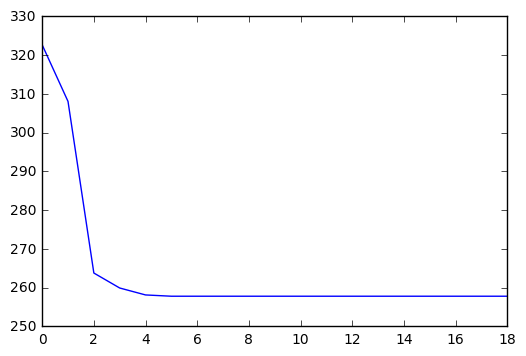

In [39]:
error_k = []
for k in range(1, 20):
    #print(k)

    model = AbstractModel()

    model.I = RangeSet(1, nsample)
    model.J = RangeSet(1, nvariables+1)

    model.B = Var(model.J, domain=Reals)
    model.A = Var(model.J, domain=Binary)

    model.t = Var(model.I, domain=NonNegativeReals)


    def obj_func(model):
        return sum(model.t[i] for i in model.I)
    model.OBJ = Objective(rule=obj_func, sense=minimize)

    def const1(model, i):
        return -(sum((model.B[j]*X[i-j, j-1]) for j in model.J)) - model.t[i] <= -Y[i-1]
    model.const1 = Constraint(model.I, rule=const1)

    def const2(model, i):
        return -(sum((model.B[j]*X[i-1, j-1]) for j in model.J)) + model.t[i] >= -Y[i-1]
    model.const2 = Constraint(model.I, rule=const2)

    def const3(model, i):
        return model.t[i] >= 0
    model.const3 = Constraint(model.I, rule=const3)

    def const4(model, j):
        return model.B[j] >= -M*model.A[j]
    model.const4 = Constraint(model.J, rule=const4)

    def const5(model, j):
        return model.B[j] <= M*model.A[j]
    model.const5 = Constraint(model.J, rule=const5)

    def const6(model):
        return sum(model.A[j] for j in model.J) <=k
    model.const6 = Constraint(rule=const6)
    
    instance = model.create_instance()
    results = opt.solve(instance)
    
    error_k.append(sum_error(instance))
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(error_k)   

In [40]:
instance.pprint()

2 RangeSet Declarations
    I : Dim=0, Dimen=1, Size=30, Domain=Integers, Ordered=True, Bounds=(1, 30)
        Virtual
    J : Dim=0, Dimen=1, Size=6, Domain=Integers, Ordered=True, Bounds=(1, 6)
        Virtual

3 Var Declarations
    A : Size=6, Index=J
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     1 :     1 : False : False : Binary
          2 :     0 :     1 :     1 : False : False : Binary
          3 :     0 :     1 :     1 : False : False : Binary
          4 :     0 :     1 :     1 : False : False : Binary
          5 :     0 :     1 :     1 : False : False : Binary
          6 :     0 :     1 :     1 : False : False : Binary
    B : Size=6, Index=J
        Key : Lower : Value     : Upper : Fixed : Stale : Domain
          1 :  None :         5 :  None : False : False :  Reals
          2 :  None :  -0.54792 :  None : False : False :  Reals
          3 :  None :   3.01062 :  None : False : False :  Reals
          4 :  None :   2.46105 :

## Exercise 5

Another possibility to find β is the robust linear regression problem that exploits the robustness of the error median against outliers. It can be formulated as:

$$ \min_{\beta} \, median\, (|y_1-\beta ' x_1|, ..., |y_n - \beta ' x_n| ) $$

Formulate this model as a MILP and implement and solve it in Pyomo. Due to its computational complexity, consider as an input n=30 random observations (i=1,...,30), from a linear regression model with m=5 variables (j=1,...,5).

$$ \min_{t,\beta}\sum^n_{i=1} t_i $$
$$s.t. \, -t \leq y-X\beta \leq t$$
$$t \geq 0 $$

$$ A_j=
  \begin{cases}
    1       & \quad \text{if } \text{feature is used}\\
    0  & \quad \text{otherwise } \\
  \end{cases}
$$

$$\sum_{j=1}^m A_j \leq k$$
$$-MA_j \leq \beta_j$$
$$MA_j \geq \beta_j $$

$$ O_i=
  \begin{cases}
    1       & \quad \text{if } \text{observation i is an outlier}\\
    0  & \quad \text{otherwise } \\
  \end{cases}
$$

$$\sum_{i=1}^m O_i \leq \gamma$$
$$-t_i-MO_i \leq y_i - \beta X_i $$
$$t_i+MO_i \geq y_i - \beta X_i $$

In [19]:
nsample = 30
nvariables = 5
X0=np.ones([nsample, 1])
X1=np.random.uniform(0, 10, ([nsample,nvariables]))
X=np.concatenate([X0, X1], axis=1)
error=np.random.normal(0, 1, (nsample,1))
beta=np.random.uniform(-5, 5, size=([nvariables+1, 1]))
Y=np.dot(X, beta)+error

In [34]:
k=5
M=5

# max number of outliers
G=4

model = AbstractModel()


model.I = RangeSet(1, nsample)
model.J = RangeSet(1, nvariables+1)

model.B = Var(model.J, domain=Reals)
model.A = Var(model.J, domain=Binary)

model.O = Var(model.I, domain=Binary)
model.t = Var(model.I, domain=NonNegativeReals)

 
def obj_func(model):
    return sum(model.t[i] for i in model.I)
model.OBJ = Objective(rule=obj_func, sense=minimize)

def const1(model, i):
    return -(sum((model.B[j]*X[i-j, j-1]) for j in model.J)) - model.t[i] <= -Y[i-1]
model.const1 = Constraint(model.I, rule=const1)

def const2(model, i):
    return -(sum((model.B[j]*X[i-1, j-1]) for j in model.J)) + model.t[i] >= -Y[i-1]
model.const2 = Constraint(model.I, rule=const2)

def const3(model, i):
    return model.t[i] >= 0
model.const3 = Constraint(model.I, rule=const3)

def const4(model, j):
    return model.B[j] >= -M*model.A[j]
model.const4 = Constraint(model.J, rule=const4)

def const5(model, j):
    return model.B[j] <= M*model.A[j]
model.const5 = Constraint(model.J, rule=const5)

def const6(model):
    return sum(model.A[j] for j in model.J) <=k
model.const6 = Constraint(rule=const6)

def const7(model, i):
    M = np.median(model.t) #10000
    return -model.t[i] - M* model.O[i] + sum((model.B[j]*X[i-1, j-1]) for j in model.J) <= Y[i-1]
model.const7 = Constraint(model.I, rule=const7)

def const8(model, i):
    M = np.median(model.t) #10000
    return model.t[i] + M* model.O[i] + sum((model.B[j]*X[i-1, j-1]) for j in model.J) >= Y[i-1]
model.const8 = Constraint(model.I, rule=const8)

def const9(model):
    return sum(model.O[i] for i in model.I) <= G
model.const9 = Constraint(rule=const9)




In [35]:
instance = model.create_instance()
results = opt.solve(instance)
print(results)


Problem: 
- Lower bound: 263.9424114
  Upper bound: 263.9424114
  Number of objectives: 1
  Number of constraints: 165
  Number of variables: 73
  Number of nonzeros: 991
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.0125708580017
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [36]:
instance.pprint()

2 RangeSet Declarations
    I : Dim=0, Dimen=1, Size=30, Domain=Integers, Ordered=True, Bounds=(1, 30)
        Virtual
    J : Dim=0, Dimen=1, Size=6, Domain=Integers, Ordered=True, Bounds=(1, 6)
        Virtual

4 Var Declarations
    A : Size=6, Index=J
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     1 :     1 : False : False : Binary
          2 :     0 :     1 :     1 : False : False : Binary
          3 :     0 :     1 :     1 : False : False : Binary
          4 :     0 :     1 :     1 : False : False : Binary
          5 :     0 :     0 :     1 : False : False : Binary
          6 :     0 :     1 :     1 : False : False : Binary
    B : Size=6, Index=J
        Key : Lower : Value     : Upper : Fixed : Stale : Domain
          1 :  None :         5 :  None : False : False :  Reals
          2 :  None : -0.483022 :  None : False : False :  Reals
          3 :  None :   3.03381 :  None : False : False :  Reals
          4 :  None :   2.46144 :